In [8]:
import pandas as pd
import numpy as np
import geopandas
import matplotlib.pyplot as plt
from shapely.geometry import Point
import os
import folium
import json
from datetime import *

In [ ]:
#Read the raw data and the yelp scraping and merge them together
df = pd.read_csv("raw_data.csv")
df_restaurant = pd.read_csv("restaurants_raw_data.csv")

In [23]:
#Need to start by cleaning the mess that is the yelp data
from fuzzywuzzy import fuzz

df_price["yelp_fuzz"] = df_price[["dba","yelp_name"]].apply(lambda x: fuzz.partial_ratio(x['dba'], x['yelp_name'].upper()), axis=1)
#Losing ~1/10 of the data... aouch


In [31]:
#Convert inspection date to datetime and keep a count for the past 15 months of the amounts of inspections
df["inspection_date_datetime"] = pd.to_datetime(df["inspection_date"])
last_year_date = pd.Timestamp(date(2017, 6, 15))
df_last_year = df[df["inspection_date_datetime"] > last_year_date].drop_duplicates(["camis","inspection_date_datetime"])
df["inspection_count"] = df["camis"].map(df_last_year["camis"].value_counts())
df["inspection_count"] = df["inspection_count"].fillna(0)
df["inspection_count"] = df["inspection_count"].astype(int)

In [ ]:
#Keeping only one record for each restaurant and add the inspection count variable to the dataframe
df = df.sort_values("inspection_date_datetime",ascending=False)
df = df.drop_duplicates("camis")
df = df[df["grade"].notnull()]
df_restaurant = df_restaurant.drop_duplicates(["dba","street","zipcode"])
df_merged = df.merge(df_restaurant, on=["dba","street","zipcode"],how="left")

In [67]:
#Aggregate the data per zipcode to create the choropleth
df_map = df_map.dropna(subset=['zipcode'])
df_map.zipcode.unique()
df_map["zipcode"] = df_map["zipcode"].astype(int)
df = df_map.groupby("zipcode")["score"].mean() 
new_df = pd.DataFrame(data = {"zip": df.index, "mean_score": df}) 
df_proportion =  100*(df_map[df_map["score"] < 13].groupby("zipcode")["score"].count() / df_map.groupby("zipcode")["score"].count())
new_df = pd.DataFrame(data = {"zip": df.index,"proportion": df_proportion}) 
new_df["zip"] = new_df["zip"].astype(str)

In [48]:
#Prepare the map template for the choropleth
with open("nyc-zip-code-tabulation-areas-polygons.geojson","r") as jsonFile:
    data = json.load(jsonFile)
tmp = data
geozips = []
for i in range(len(tmp["features"])):
    if tmp["features"][i]["properties"]["postalCode"] in list(new_df["zip"].unique().astype(str)):
        geozips.append(tmp["features"][i])
        
new_json = dict.fromkeys(["type","features"])
new_json["type"] = "FeatureCollection"
new_json["features"] = geozips

open("updated-file.json","w").write(json.dumps(new_json, sort_keys = True, indent=4, separators = (",",": ")))

1749713

In [149]:
def create_map(table,zips,mapped_feature, add_text=""):
    #Create the map based on the zip-coded data and the feature
    nyc_geo = r"updated-file.json"
    m = folium.Map(location = [40.7128, -74.0060], zoom_start = 11)
    m.choropleth(
        geo_data = nyc_geo,
        fill_opacity = 0.7,
        line_opacity = 0.2,
        data = table,
        key_on = "feature.properties.postalCode",
        columns = [zips,mapped_feature],
        fill_color = "RdYlGn",
        legend_name = "Percentage of Restaurants Graded A Across NYC",
        threshold_scale= [50, 60, 70, 80, 90, 100]
    )
    folium.LayerControl().add_to(m)
    m.save(outfile = mapped_feature + "_map.html")

In [150]:
create_map(new_df,"zip","proportion")

In [ ]:
'''os.environ["PROJ_LIB"] = "C:\ProgramData\Anaconda3\Library\share"
df_map = df_for_map[["score","yelp_latitude","yelp_longitude"]]
df_map = df_map[(df_map["yelp_longitude"] >= -74.257159) & (df_map["yelp_longitude"]  <= -73.699215)]
df_map = df_map[(df_map["yelp_latitude"] >= 40.495992) & (df_map["yelp_latitude"]  <= 40.915568)]
df_map['Coordinates'] = list(zip(df_map.yelp_longitude, df_map.yelp_latitude))
df_map['Coordinates'] = df_map['Coordinates'].apply(Point)

df =df_map[["score","Coordinates"]]
gdf = geopandas.GeoDataFrame(df, geometry='Coordinates')
gdf.crs = {'init': 'epsg:4326', 'no_defs': True}
nybb_path = geopandas.datasets.get_path('nybb')
boros = geopandas.read_file(nybb_path)
gdf.to_crs(boros.crs, inplace=True)
manhattan = boros.geometry[3]
brooklyn = boros.geometry[2]
in_mn = gdf.geometry.within(manhattan)
ax = boros.plot()
gdf[in_mn].plot(ax=ax,column="score",edgecolor='black', scheme='quantiles',cmap='Blues')
plt.show()
'''

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002258913B518>],
      dtype=object)

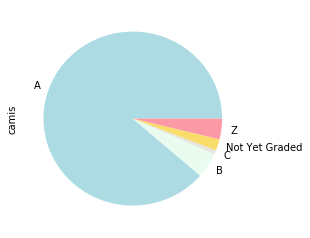

In [8]:
#Initiate the color palette
palette =["#acdbe3", "#eafcef","#e7e5d9","#fadc6a","#fb9aa6"]
#Aggregate Stats by Grade in a pie chart
#TODO: 1.Use synthetic grade? 2. Add data label in center with percentage
plot1df = df_merged.groupby("grade")["camis"].count() / df_merged.groupby("grade")["camis"].count().sum()
plot1df.plot(kind="pie", subplots = True, figsize=(4,4), colors=palette)

In [5]:
def is_food(cuisine_description):
    #Separates food restaurants with the other types of business
    food = ["American","Peruvian","Soups & Sandwiches","Chinese","Sandwiches","Mexican","Chicken","Turkish","Sandwiches/Salads/Mixed Buffet","Hamburgers","Chinese/Japanese","Italian","Spanish","Latin (Cuban, Dominican, Puerto Rican, South & Central American)","French","Pizza/Italian","Creole","Pizza","Japanese","Seafood","Asian","African","Barbecue","Jewish/Kosher","Tapas","Caribbean","Salads","Steak","Tex-Mex","Mediterranean","Pakistani","Irish","Vegetarian","Bangladeshi","Australian","Thai","Soups","Middle Eastern","Russian","Indian","Brazilian","Greek","Korean","Vietnamese/Cambodian/Malaysia","Hotdogs","Hawaiian","Soul Food", "Filipino","Creole/Cajun","Eastern European","Armenian","Afghan","Chinese/Cuban","English","Polish","Continental","Hotdogs/Pretzels","German","Egyptian","Indonesian","Ethiopian","Moroccan","Portuguese","Californian","Cajun","Scandinavian","Southwestern","Chilean","Iranian","Polynesian","Czech","Basque"]
    other = ["Pancakes/Waffles","Not Listed/Not Applicable","Nuts/Confectionary","Fruits/Vegetables"]
    if cuisine_description in food:
        category = "Food"
    elif cuisine_description in other:
        category = "Other"
    else:
        category = cuisine_description
    
    return category

In [17]:
#Is there any distinction by cuisine?
food_type = df_merged["cuisine_description"].unique()
df_merged["food"] = df_merged["cuisine_description"].apply(is_food)

food
Bagels/Pretzels                                              149
Bakery                                                       660
Bottled beverages, including water, sodas, juices, etc.       96
CafÃ©/Coffee/Tea                                            1568
Delicatessen                                                 257
Donuts                                                       513
Food                                                       18796
Ice Cream, Gelato, Yogurt, Ices                              313
Juice, Smoothies, Fruit Salads                               375
Other                                                        287
Name: camis, dtype: int64

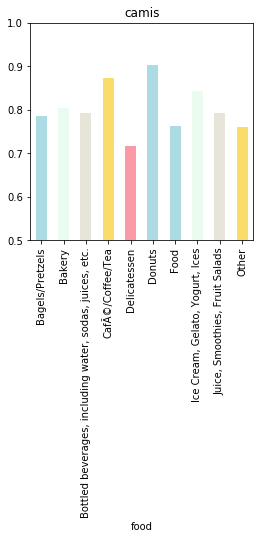

In [18]:
plot2df = df_merged[df_merged["score"] < 13].groupby("food")["camis"].count() / df_merged.groupby("food")["camis"].count()
plot2df.plot(kind="bar", subplots = True, figsize=(4,4),color=palette,ylim = (0.5,1))
df_merged.groupby("food")["camis"].count()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000231B03D40F0>],
      dtype=object)

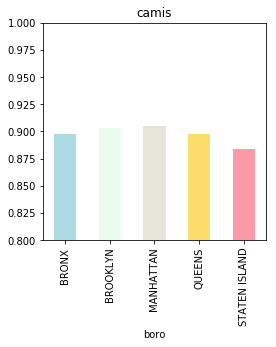

In [147]:
#Is there any distinction by Borough?
df_boro = df_merged[df_merged["boro"] != "Missing"]
plot2df = df_boro[df_merged["score"] < 14].groupby("boro")["camis"].count() / df_boro.groupby("boro")["camis"].count()
plot2df.plot(kind="bar", subplots = True, figsize=(4,4),ylim = (0.8,1),color=palette)

In [6]:
def reformat_price(price):
    #Simply reformats the price levels of the different businesses
    if price == "$":
        category = "1- Cheap"
    elif price == "$$":
        category = "2 - Reasonable"
    elif price == "$$$":
        category = "3 - Expensive"
    elif price == "$$$$":
        category = "4 - Luxurious"
    return category

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000022583A5ADD8>],
      dtype=object)

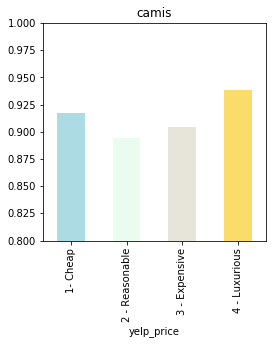

In [21]:
#Is there any distinction by price point?
price_option=["$","$$","$$$","$$$$"]
df_price= df_merged[df_merged["yelp_price"].isin(price_option)]
df_price["yelp_price"] = df_price["yelp_price"].apply(reformat_price)
df_price = df_price.sort_values(by=["yelp_price"],ascending = True)
plot3df = df_price[df_price["score"] < 14].groupby("yelp_price")["camis"].count() / df_price.groupby("yelp_price")["camis"].count()
plot3df.plot(kind="bar", subplots = True, figsize=(4,4),ylim = (0.8,1),color=palette)

,dba,yelp_name,score,yelp_price,yelp_fuzz
11652,NIGHT MARKET BBQ,Night Market BBQ,10.0,1- Cheap,100
22056,MIKE'S PIZZA,Mike's Pizza,9.0,1- Cheap,100
3367,BLANK CAFE,Blank Cafe & Bistro,27.0,1- Cheap,100
20727,CHIPOTLE MEXICAN GRILL,Chipotle Mexican Grill,8.0,1- Cheap,100
22058,KINGS KITCHEN A,King's Kitchen,12.0,1- Cheap,93
1317,SUBWAY,Subway,9.0,1- Cheap,100
1316,SAMMY'S HALAL,Sammy's Halal,14.0,1- Cheap,100
20704,HAPPY FAMILY,Happy Family,11.0,1- Cheap,100
1315,YUMMY MACHI,Yummy Machi,13.0,1- Cheap,100
20706,BUREK'S PIZZA,Burek's Pizza,5.0,1- Cheap,100


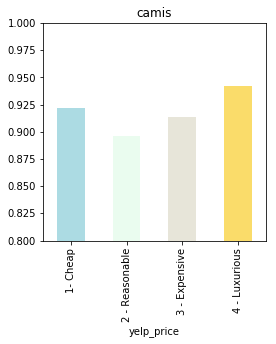

In [24]:
df_cleaned = df_price[df_price["yelp_fuzz"]>65]
df_cleaned = df_cleaned.sort_values(by=["yelp_price"],ascending = True)
plot4df = df_cleaned[df_cleaned["score"] < 14].groupby("yelp_price")["camis"].count() / df_cleaned.groupby("yelp_price")["camis"].count()
plot4df.plot(kind="bar", subplots = True, figsize=(4,4),ylim = (0.8,1),color=palette)
df_cleaned[["dba","yelp_name","score","yelp_price","yelp_fuzz"]]

In [16]:
df_price[df_price["yelp_price"] == "4 - Luxurious"][["dba","score","yelp_name","yelp_price"]]

,dba,score,yelp_name,yelp_price
18415,LINCOLN RISTORANTE,9.0,Lincoln Ristorante,4 - Luxurious
17963,HIBISCUS RESTAURANT & LOUNGE II,12.0,Hakkasan,4 - Luxurious
7216,HUNG YIP CHINESE RESTAURANT,22.0,Jean-Georges,4 - Luxurious
8446,KEENS STEAKHOUSE,13.0,Keens Steakhouse,4 - Luxurious
23009,THE MERCER SUBMERCER,3.0,The Mercer Hotel,4 - Luxurious
7209,AQUAVIT,10.0,Aquavit,4 - Luxurious
17929,DADONG NEW YORK,9.0,DaDong New York,4 - Luxurious
22741,SPIRIT OF NEW JERSEY,11.0,Spirit of New Jersey,4 - Luxurious
8825,JUICE PRESS,10.0,Juice Press,4 - Luxurious
8620,NUSRET STEAKHOUSE,8.0,Nusr-Et,4 - Luxurious


In [ ]:
#Is there any distinction by hours of opening?

In [62]:
df_cleaned.columns

Index(['action', 'boro', 'building', 'camis', 'critical_flag',
       'cuisine_description', 'dba', 'grade', 'grade_date', 'inspection_date',
       'inspection_type', 'phone', 'record_date', 'score', 'street',
       'violation_code', 'violation_description', 'zipcode',
       'inspection_date_datetime', 'searched', 'yelp_id', 'yelp_price',
       'yelp_rating', 'yelp_review_count', 'yelp_latitude', 'yelp_longitude',
       'yelp_name', 'yelp_is_claimed', 'yelp_hours', 'yelp_transaction_type',
       'yelp_fuzz', 'chain_size'],
      dtype='object')

             yelp_rating     score
yelp_rating     1.000000  0.035292
score           0.035292  1.000000


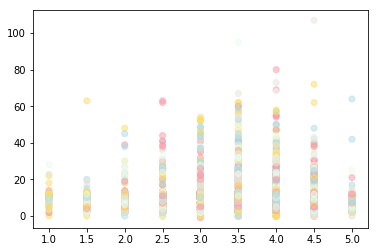

In [55]:
df_cleaned["yelp_rating"].unique()
plt.scatter(df_cleaned["yelp_rating"], df_cleaned["score"], c=palette, alpha=0.5)
print(df_cleaned[["yelp_rating","score"]].corr())

                   yelp_review_count     score
yelp_review_count           1.000000  0.054814
score                       0.054814  1.000000


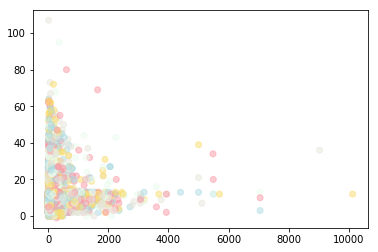

In [57]:
plt.scatter(df_cleaned["yelp_review_count"], df_cleaned["score"], c=palette, alpha=0.5)
print(df_cleaned[["yelp_review_count","score"]].corr())

            chain_size     score
chain_size    1.000000 -0.115716
score        -0.115716  1.000000


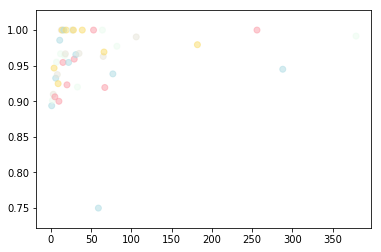

In [25]:
#Is there any distinction by being a chain? AS EXPECTED
df_cleaned["chain_size"] = df_cleaned["dba"].map(df_cleaned["dba"].value_counts())
plot5df = df_cleaned[df_cleaned["score"] < 14].groupby("chain_size")["camis"].count() / df_cleaned.groupby("chain_size")["camis"].count()
plt.scatter(plot5df.index, plot5df, c=palette, alpha=0.5)
print(df_cleaned[["chain_size","score"]].corr())

1378     True
3319     True
20726    True
20349    True
20835    True
1153     True
3383     True
1270     True
20618    True
20595    True
4155     True
4160     True
4067     True
4034     True
20188    True
4120     True
4088     True
20214    True
15403    True
15392    True
15430    True
11689    True
10119    True
9728     True
9814     True
15891    True
9835     True
16437    True
10055    True
16298    True
         ... 
8018     True
9497     True
8959     True
8837     True
8083     True
8562     True
10805    True
10856    True
10431    True
10709    True
10804    True
11505    True
13425    True
11972    True
15083    True
14336    True
20170    True
17977    True
14031    True
22322    True
20878    True
7254     True
4146     True
21023    True
21022    True
17318    True
20527    True
17294    True
16179    True
21292    True
Name: is_deli_bool, Length: 146, dtype: bool


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000225848221D0>],
      dtype=object)

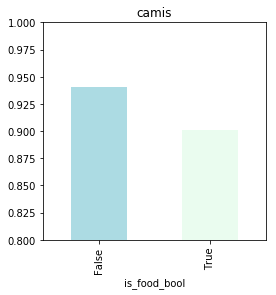

In [38]:
#simply seggregate food or not and delicatessen or not
df_cleaned["is_food_bool"] = [x == "Food" for x in df_cleaned["food"]]
df_cleaned["is_deli_bool"] = [x == "Delicatessen" for x in df_cleaned["food"]]
plot7df = df_cleaned[df_cleaned["score"] < 14].groupby("is_food_bool")["camis"].count() / df_cleaned.groupby("is_food_bool")["camis"].count()
plot7df.plot(kind="bar", subplots = True, figsize=(4,4),ylim = (0.8,1),color=palette)
#plot8df = df_cleaned[df_cleaned["score"] < 14].groupby("is_deli_bool")["camis"].count() / df_cleaned.groupby("is_deli_bool")["camis"].count()
#plot8df.plot(kind="bar", subplots = True, figsize=(4,4),ylim = (0.8,1),color=palette)

In [28]:
#Also, I should isolate food throughout the analysis to avoid bias
#What do we do with all the restaurants/biz that i couldnt find on yelp? It does give an info
#It definitely helps understand why the ratio goes up as its probably correlated
df_cleaned["std_yelp_rating"] = (df_cleaned["yelp_rating"]-df_cleaned["yelp_rating"].mean())/df_cleaned["yelp_rating"].std()
df_cleaned["std_yelp_review_count"] = (df_cleaned["yelp_review_count"]-df_cleaned["yelp_review_count"].mean())/df_cleaned["yelp_review_count"].std()
df_cleaned["std_chain_size"] = (df_cleaned["chain_size"]-df_cleaned["chain_size"].mean())/df_cleaned["chain_size"].std()
df_cleaned.to_csv("cleanedv1.csv")